In [1]:
from os.path import join
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import os
import pandas as pd
import numpy as np
import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
print("Import Clear")

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


Import Clear


In [2]:
#1. 데이터 전처리를 위한 과정
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data' #데이터 경로

train_data_path = join(data_dir, 'train.csv') #훈련 데이터 파일
test_data_path = join(data_dir, 'test.csv')  #테스트 데이터 파일

train = pd.read_csv(train_data_path) #훈련데이터를 train에 저장
test = pd.read_csv(test_data_path) #테스트데이터를 test에 저장



#훈련에 필요하지 않는 데이터 컬럼에서 삭제 --> 두번작동할 경우 오류가 생기므로 초회 한번만 작동하고 주석화함
train_price_data = train['price'] #삭제전 원본을 다른 곳에 저장
print(train_price_data) #저장된 정보 확인

del train['price'] #price는 타겟이기 때문에 삭제
del train['id'] #불필요한 값이므로 삭제

del test['id'] #불필요한 값이므로 삭제
print(train.columns) #id 값과 price값이 컬럼에서 사라진걸 확인
print(test.columns) #id값이 컬럼에서 사라진걸 확인

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [3]:
#train_date를 보기 좋게 변경
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) #TypeError: 'int' object is not subscriptable 발생 --> 경로를 초기화하면 초회 정사적으로 출력되고 두번째부터 같은 오류가 발생함 
train.head() #변경된 date확인

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
#test_date를 보기 좋게 변경
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test.head()#변경된 date확인

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


<AxesSubplot:xlabel='price', ylabel='Density'>

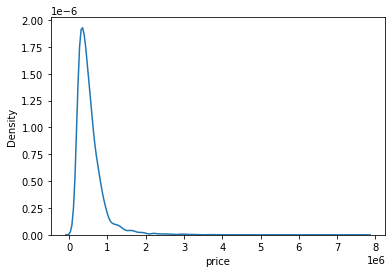

In [5]:
#앞에서 저장한 price정보를 그래프화하여 표시
sns.kdeplot(train_price_data,shade = False)

In [6]:
#2. 모델 생성 및 학습
random_state = 2020 #랜덤 시드 설정값 (지정하지 않을 경우(None) 모델 내부에서 임의로 지정됨)

#모델 생성
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest] #생성된 모델을 models에 저장

In [7]:
#GridSearch 함수 생성
def my_GridSearch(model, train , train_price_data, param_grid, verbose = 2, n_jobs = 5):
    #GridSearch 생성
    model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)
    
    model.fit(train, train_price_data) #모델 학습
    
    params = model.cv_results_['params'] 
    score = model.cv_results_['mean_test_score']#결과값 저장
    
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSE'] = np.sqrt(-1 * results['score'])
    
    sort_results = results.sort_values('RMSE') #정렬
    
    
    return sort_results

In [8]:
#점수를 계산하는 함수 생성
def get_scores(models, train, train_price_data):
    dataframe = {}
    
    for model in models:
        model_name = model.__class__.__name__ #적용중인 모델 이름
        
        X_train, X_test, y_train, y_test = train_test_split(train, train_price_data, random_state=random_state, test_size=0.2) #데이터셋 분리
        
        model.fit(X_train, y_train) #모델 학습
        
        y_pred = model.predict(X_test) #에측
        
        dataframe[model_name] = np.sqrt(mean_squared_error(y_test, y_pred)) #예측 결과의 RMSE값 저장
        
        score_df = pd.DataFrame(dataframe, index=['RMSE']).T.sort_values('RMSE', ascending=False) #데이터 프레임에 저장
    
    return dataframe

In [9]:
get_scores(models, train, train_price_data)

{'GradientBoostingRegressor': 130561.80232135103,
 'XGBRegressor': 120062.22501255783,
 'LGBMRegressor': 120637.37922563334,
 'RandomForestRegressor': 125303.70068586833}

In [10]:
#LGBM 모델
model_01 = LGBMRegressor(random_state=random_state) #lightGBM 모델 생성

param_grid = { #탐색할 파라미터의 종류 type = dictionary
    'n_estimators' : [290, 300, 310], 
    'max_depth' : [20],
    'learning_rate' : [0.05],
    'num_leaves' : [50]
}

my_GridSearch(model_01, train, train_price_data, param_grid)
#LGBM 모델의 최소값 : 126,538

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSE
1,0.05,20,300,50,-1.601208e+10,126538.862444
2,0.05,20,310,50,-1.602040e+10,126571.729340
0,0.05,20,290,50,-1.603853e+10,126643.304286


In [11]:
# GradientBoosting모델
model_02 = GradientBoostingRegressor(random_state=random_state)

param_grid = {
    'n_estimators' : [800,770,780],
    'max_features' : [8],
    'max_depth' : [5],
    'learning_rate' : [0.1,0.11]
}

my_GridSearch(model_02, train, train_price_data, param_grid)
#GradientBoostingRegressor 모델의 최소값 : 115,819

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,learning_rate,max_depth,max_features,n_estimators,score,RMSE
1,0.10,5,8,770,-1.341409e+10,115819.222515
0,0.10,5,8,800,-1.341824e+10,115837.136932
2,0.10,5,8,780,-1.342053e+10,115846.993535
5,0.11,5,8,780,-1.359341e+10,116590.781906
4,0.11,5,8,770,-1.359380e+10,116592.457773
3,0.11,5,8,800,-1.359704e+10,116606.341536


In [12]:
#RandomForest모델
model_03 = RandomForestRegressor(random_state=random_state)

param_grid = {
    'n_estimators' : [350, 300],
    'max_features' : [8],
    'max_depth' : [50,25]
}
my_GridSearch(model_03, train, train_price_data, param_grid)
#RandomForest 모델의 최소값 : 134,839

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,max_features,n_estimators,score,RMSE
2,25,8,350,-1.818171e+10,134839.555715
3,25,8,300,-1.820569e+10,134928.474844
0,50,8,350,-1.829355e+10,135253.650807
1,50,8,300,-1.832267e+10,135361.246547


In [13]:
#XGBR모델 --> 오류로 인해 값을 도출하지 못하고 있음 --> 패키지 업그레이드로 해결 --> 몇차례 값을 내다가 스코어와 예측점수가 사라짐
model_04 = XGBRegressor(random_state=random_state)

param_grid = {
    'booster' : ['gbtree']
}

my_GridSearch(model_04, train, train_price_data, param_grid)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

KeyboardInterrupt: 

In [14]:
#가장 좋은 모델과 하이퍼 파라미터값
# GradientBoosting모델
model = GradientBoostingRegressor(n_estimators = 770, max_features = 8, max_depth = 5, learning_rate = 0.1, random_state=random_state)
model.fit(train, train_price_data)
prediction = model.predict(test)
prediction

array([ 551540.41271428,  474867.46117567, 1385424.54586237, ...,
        496993.04457448,  318196.36932107,  434049.09124195])

In [15]:
#3. 저장하기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data' #경로

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction #예측값 삽입
submission['price'] = submission['price'].astype(int)#정수형으로 변환
submission.head()

,id,price
0,15035,551540
1,15036,474867
2,15037,1385424
3,15038,322263
4,15039,329937


In [16]:
submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(data_dir, 'GradientBoosting', '115819')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_GradientBoosting_RMSE_115819.csv
